In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values #

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1)) #stock prices will be between 0 and 1
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
# it means that from 60 previous values RNN will try to predict the next value
# i.e. in each day we will look at the data of 60 days previously and try to predict the next day value
X_train = []
y_train = []
# this is done as we have to get the value of 60 previous days
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0]) 
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
# through this we can also add new columns like close or another indicator which
# may help the prediction(3d dataset)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [2]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# here units in neurons or memory cells of LSTM
# return sequence by default is false it is assigned true when we need to add another layer after this
# dropout is added to avoid overfitting 20% dropout as 20% neurons will be ignored during each iteration
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0595
Epoch 2/100
1198/1198 [==============================] - 8s 6ms/step - loss: 0.0066
Epoch 3/100
1198/1198 [==============================] - 8s 7ms/step - loss: 0.0059
Epoch 4/100
1198/1198 [==============================] - 8s 6ms/step - loss: 0.0057
Epoch 5/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0050
Epoch 6/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0050
Epoch 7/100
1198/1198 [==============================] - 8s 6ms/step - loss: 0.0047
Epoch 8/100
1198/1198 [==============================] - 8s 6ms/step - loss: 0.0048
Epoch 9/100
1198/1198 [==============================] - 8s 7ms/step - loss: 0.0062
Epoch 1

1198/1198 [==============================] - 5s 4ms/step - loss: 0.0018
Epoch 87/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0015
Epoch 88/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0016
Epoch 89/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0018
Epoch 90/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0019
Epoch 91/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0016
Epoch 92/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0016
Epoch 93/100
1198/1198 [==============================] - 8s 7ms/step - loss: 0.0014
Epoch 94/100
1198/1198 [==============================] - 8s 7ms/step - loss: 0.0015
Epoch 95/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0015
Epoch 96/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0013
Epoch 97/100
1198/1198 [==============================] - 8s 6ms/step - loss: 

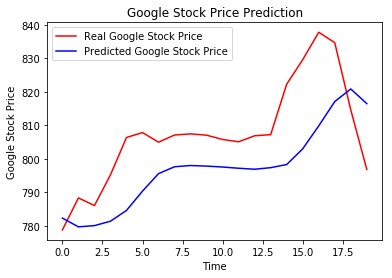

In [3]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
#  to predict the values of 2017 we would need the 60 days previous values
# from both eh test and train set as the values may be present in train set as well
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# lower boud is 60 days minus the first finalcial day of 2017 so total - test -60  
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
# get the orignal values by inverse transform
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualising the results
'''
parts which contains fast changes our model does not perform well as it introduces non linearity which 
our model can't handle and financial engineering brownian principle stock prices are not dependent on 
past changes but on smooth changes our model performs well
'''
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()